In [415]:
import tensorflow as tf
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
cd ..

/disk/users/hutmache/Projekte/BNN


In [416]:
from data import sample_generators

# Model Building

In [530]:
sigma_max = 5

assert len(x) == len(y)

#x[0] = 1e-6
x, y = sample_generators.generate_osband_sin_samples()
x = x.astype(np.float64)
y = y.astype(np.float64)

# TODO add initializer
x_data = tf.placeholder(tf.float64, [None, 1])
y_data = tf.placeholder(tf.float64, [None, 1])

def mixture_density_network(x, n_mixtures):
    with tf.device("/gpu:0"):

        #x = tf.reshape(x, [-1, 1])
        fc1 = tf.layers.dense(inputs=x, units=50, activation=tf.nn.relu)
        fc2 = tf.layers.dense(inputs=fc1, units=50, activation=tf.nn.relu)

        # Output units K*3 elements
        output_layer = tf.layers.dense(inputs=fc2, units=n_mixtures*3)
        raw_output = tf.reshape(output_layer, [-1, n_mixtures, 3])
        
        mixture_weights = tf.nn.softmax(raw_output[:, :, 0] - 
                                        tf.expand_dims(tf.reduce_max(raw_output[:, :, 0], axis=1), 1))
        #mixture_weights = tf.nn.softmax(raw_output[:, :, 0] - tf.reduce_max(raw_output[:, :, 0]))
        #mixture_weights = tf.nn.softmax(raw_output[:, :, 0])
        #mixture_weights = (tf.exp(raw_output[:, :, 0] - tf.expand_dims(tf.reduce_max(raw_output[:, :, 0], axis=1), 1)) \
        mixture_means = raw_output[:, :, 1]
        mixture_variances = sigma_max * tf.sigmoid(raw_output[:, :, 2])
        
        return mixture_weights, mixture_means, mixture_variances 



Epoch 0
Loss 1.90510374927


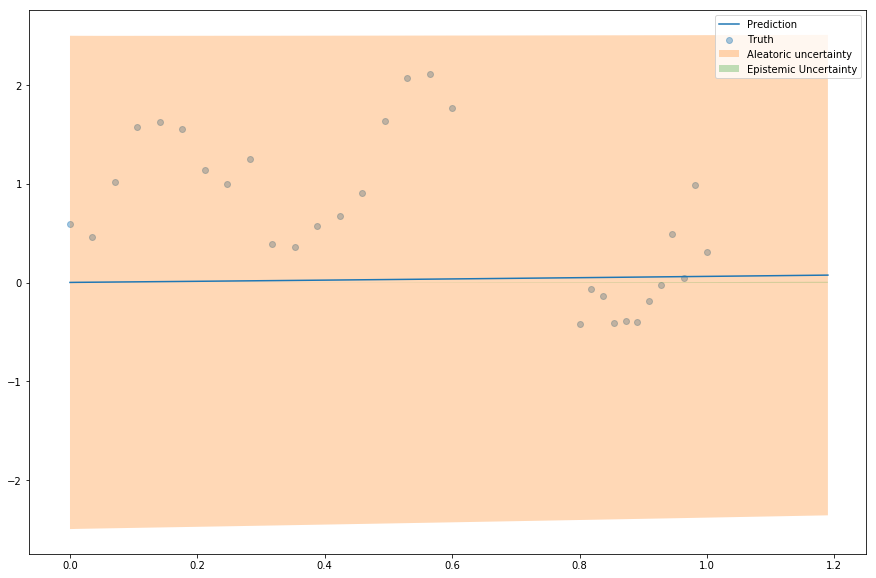

Epoch 2000
Loss 0.467825806119


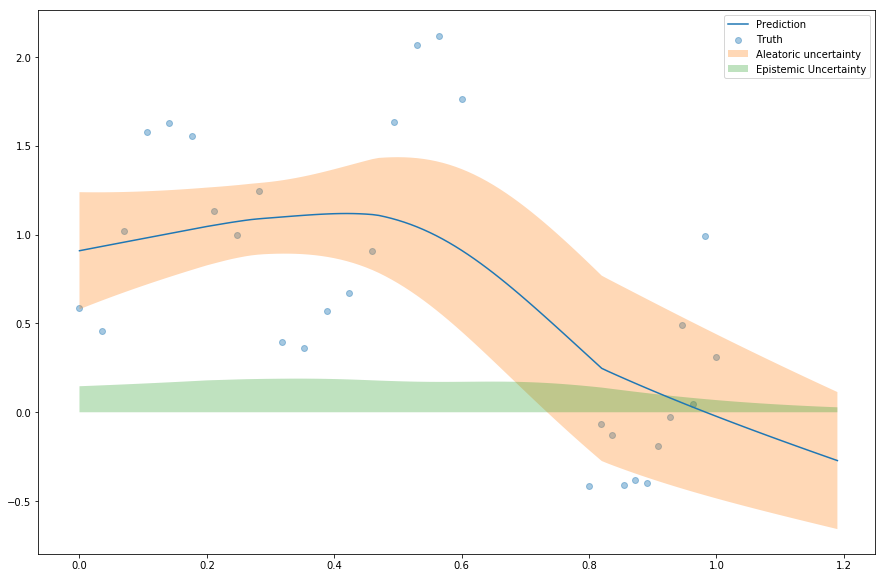

Epoch 4000
Loss 0.5482820234


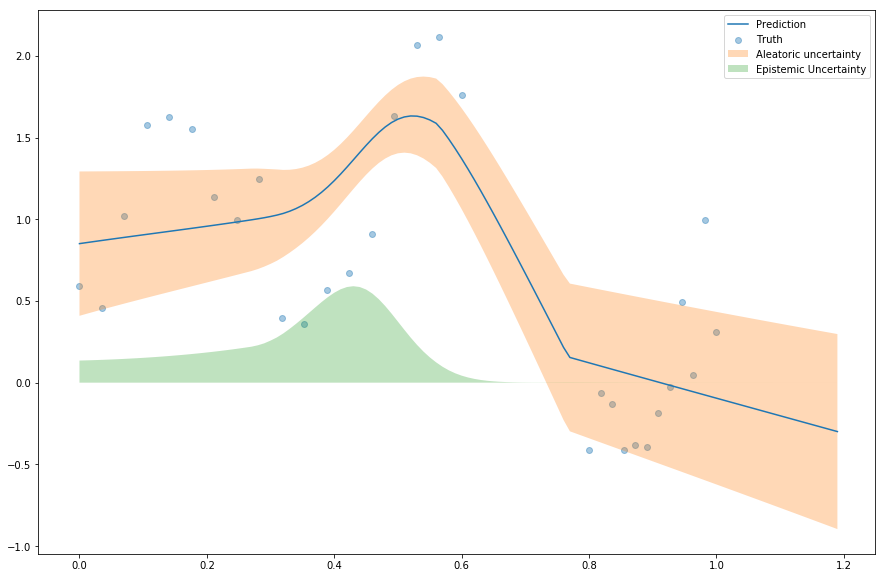

Epoch 6000
Loss 0.00279027087096


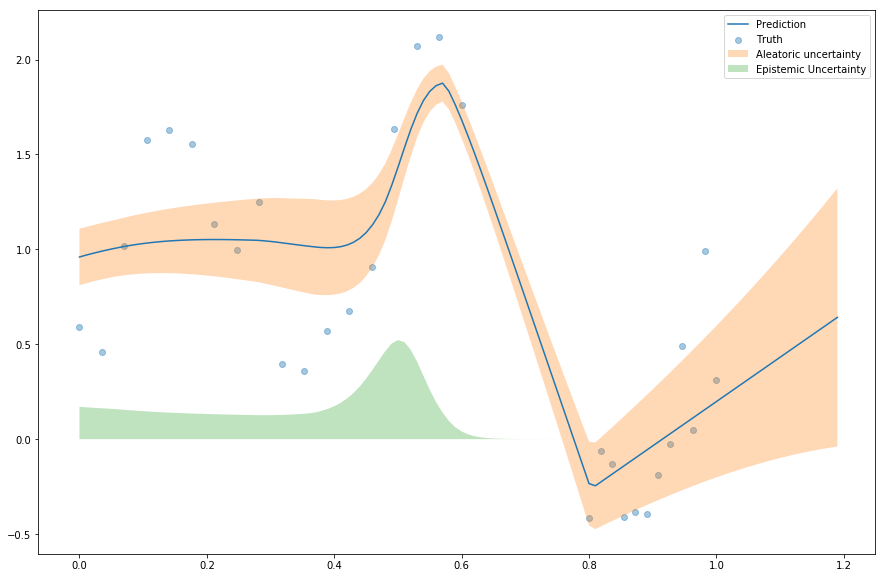

Epoch 8000
Loss -0.361505920529


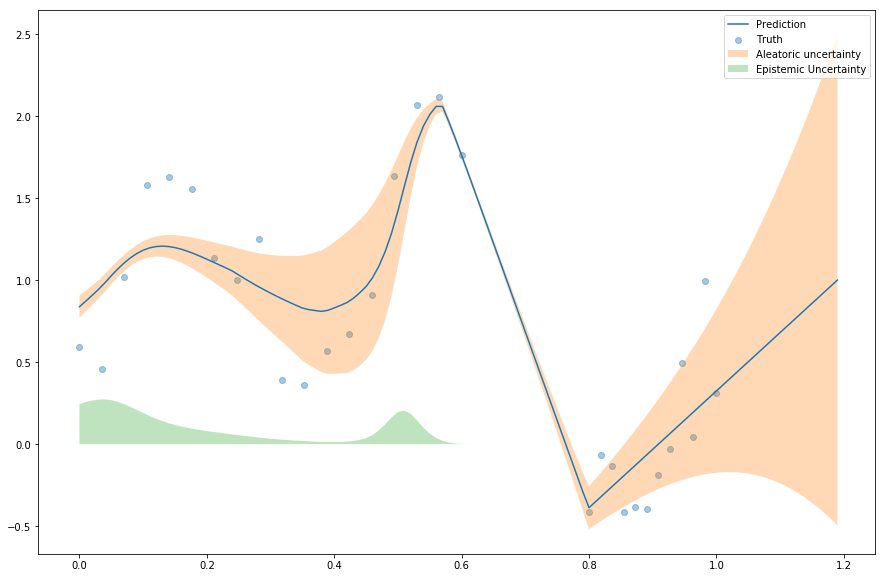

Epoch 10000
Loss 1.24418595675


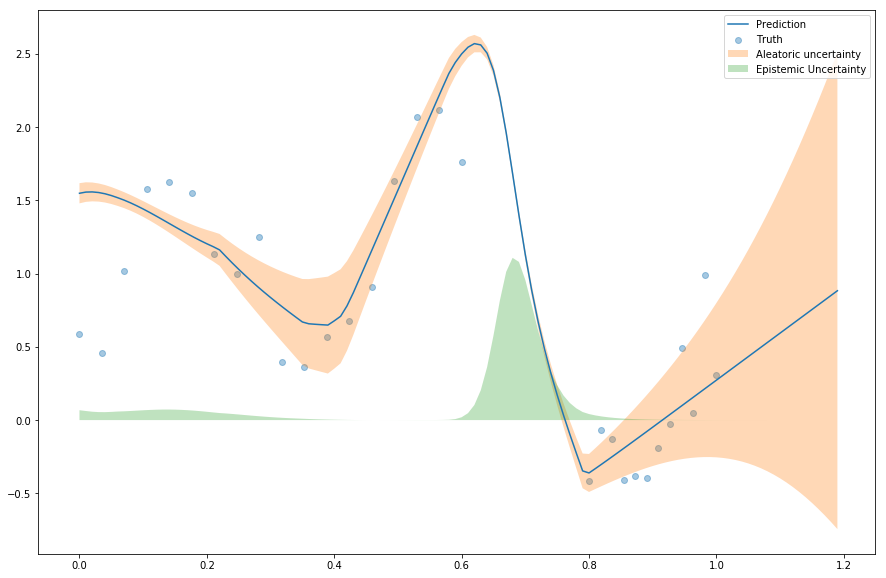

Epoch 12000
Loss 1.0498757083


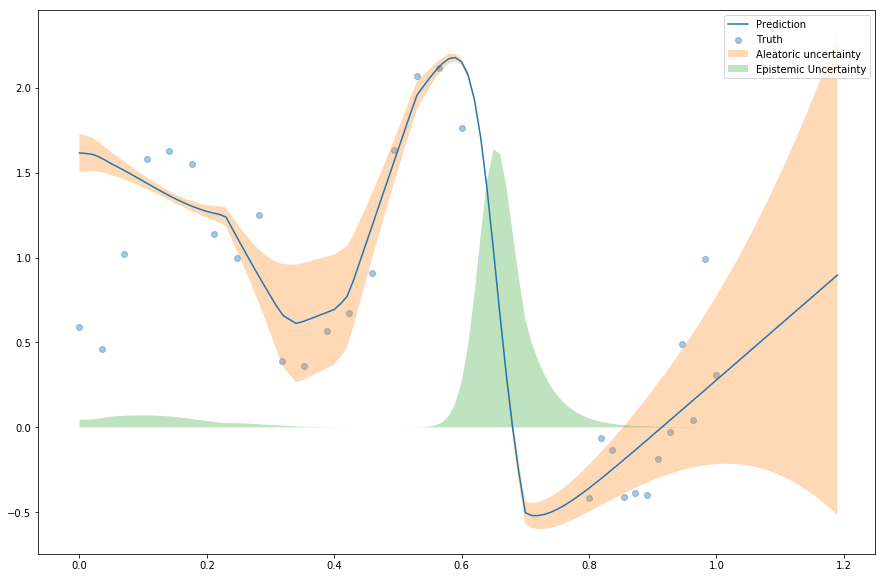

Epoch 14000
Loss 0.259895648772


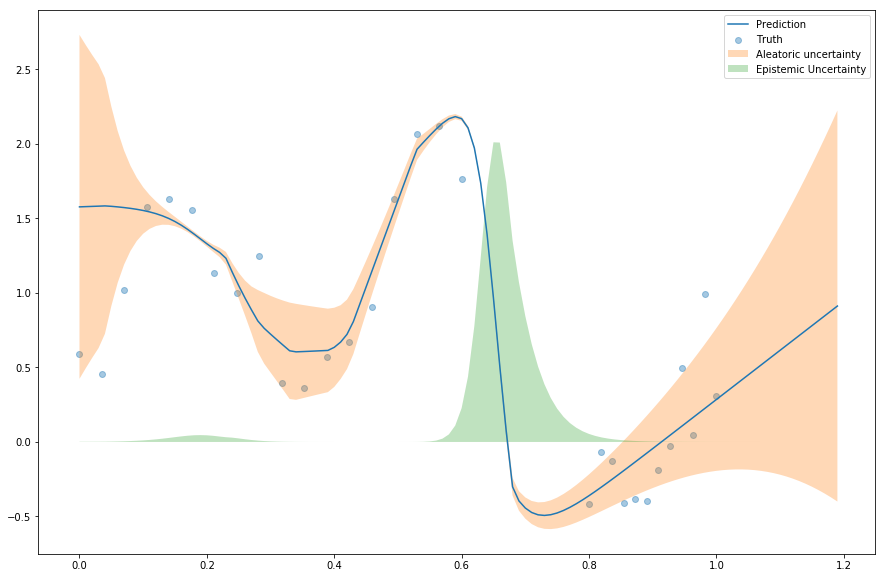

Epoch 16000
Loss -0.0650372429366


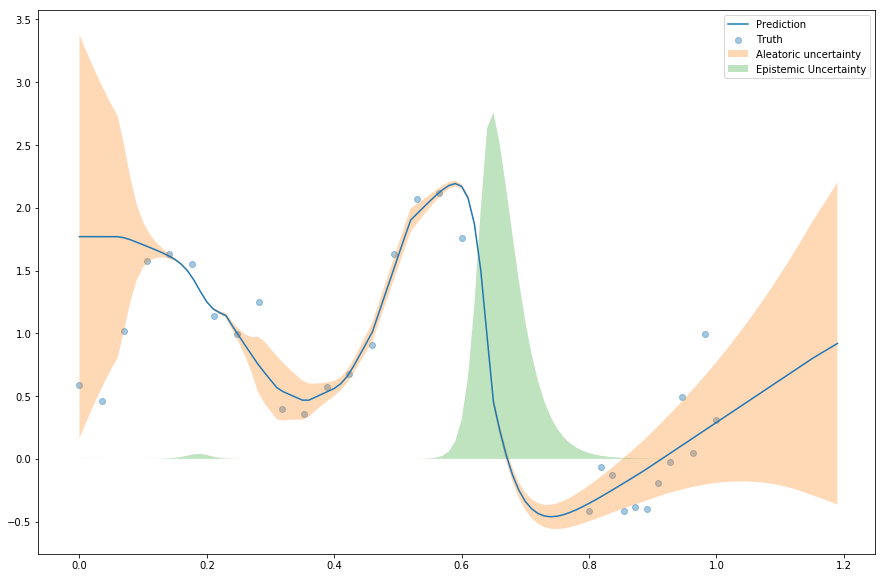

Epoch 18000
Loss 0.0325906844902


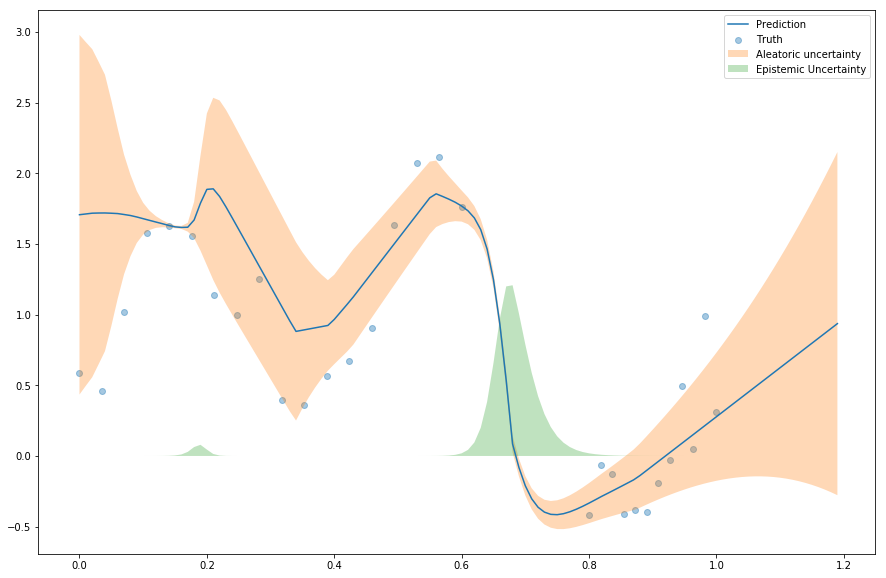

Epoch 20000
Loss -0.248755229605


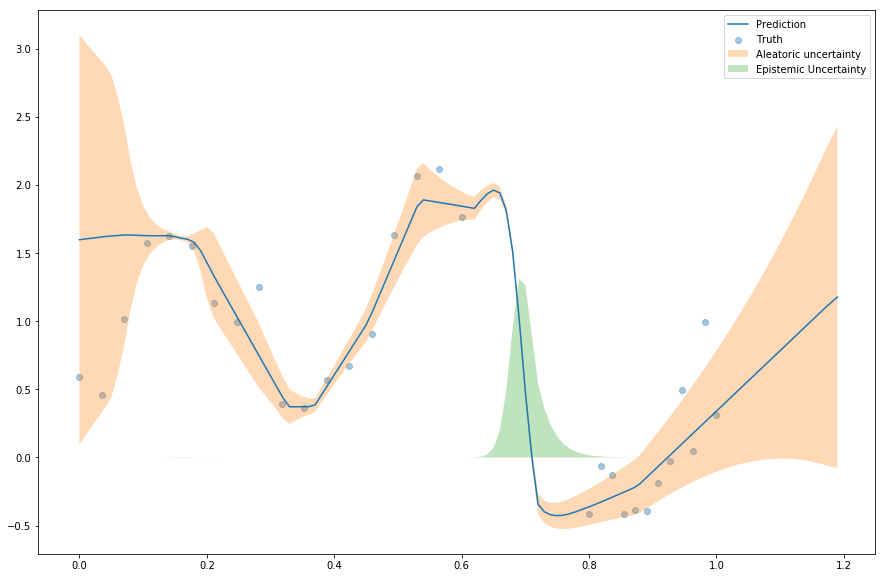

Epoch 22000
Loss -0.810424788696


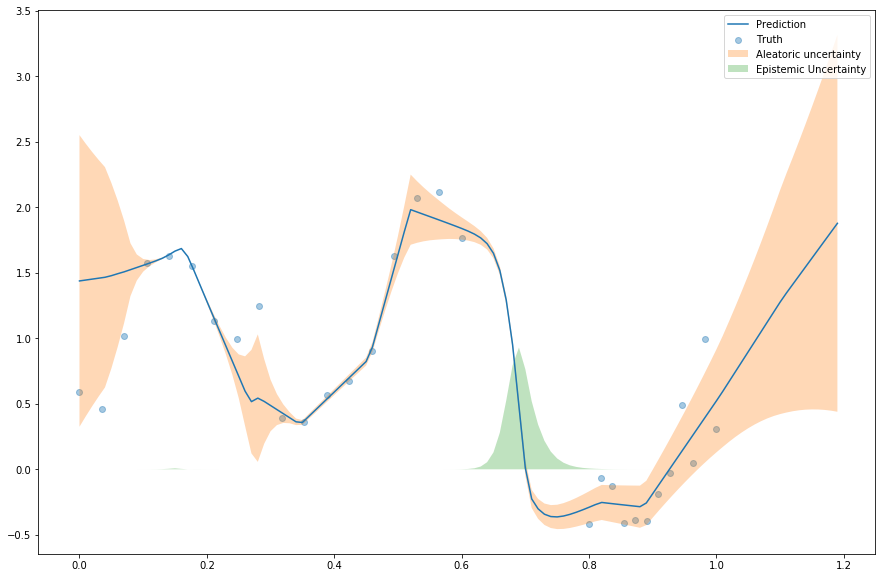

Epoch 24000
Loss -0.124313592802


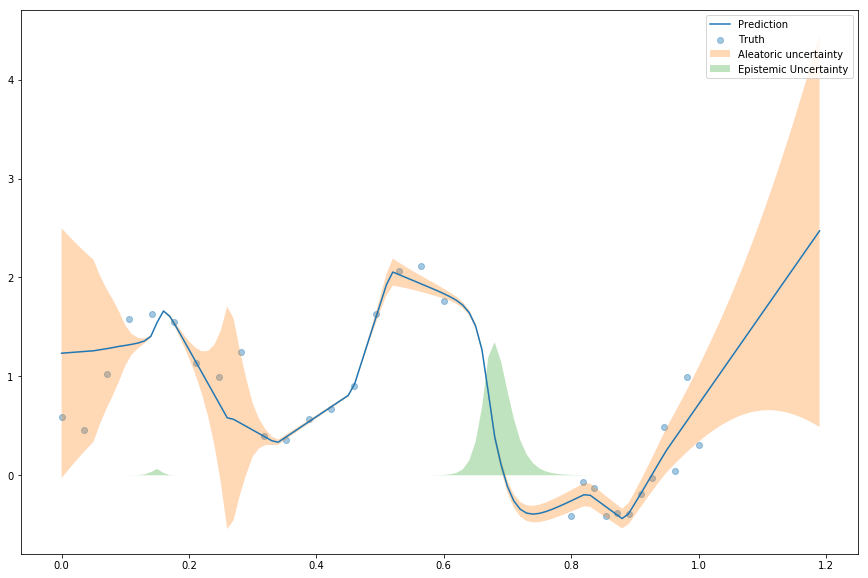

Epoch 26000
Loss -1.07414754488


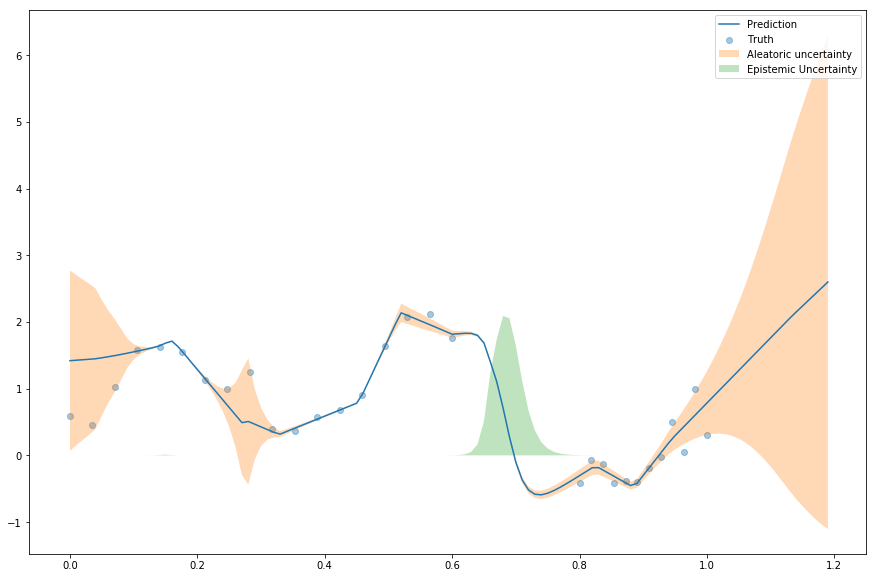

Epoch 28000
Loss -1.19843836574


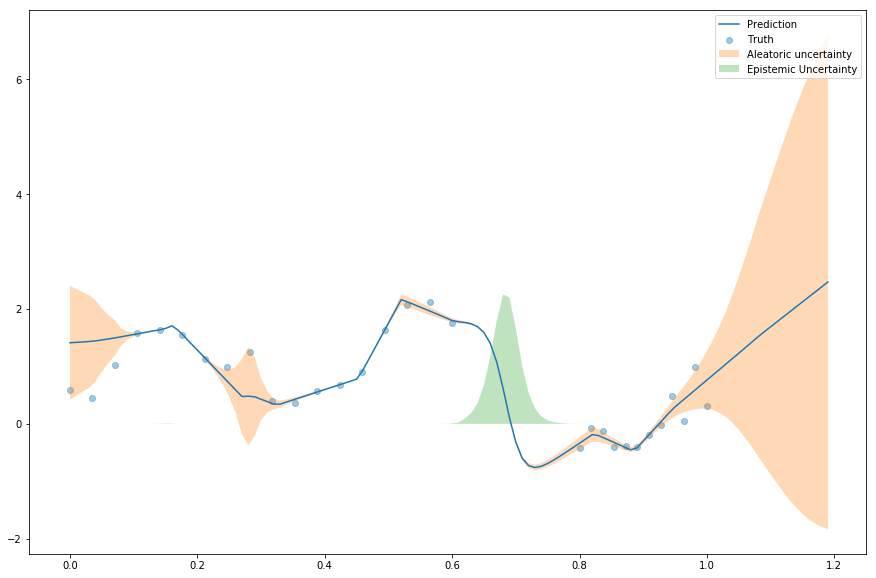

Epoch 30000
Loss -1.20339196091


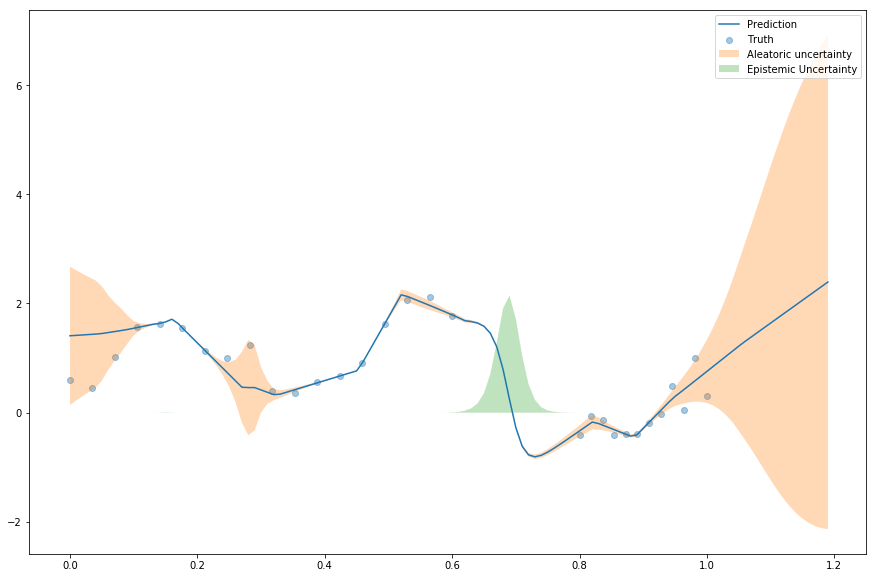

Epoch 32000
Loss -1.33793743567


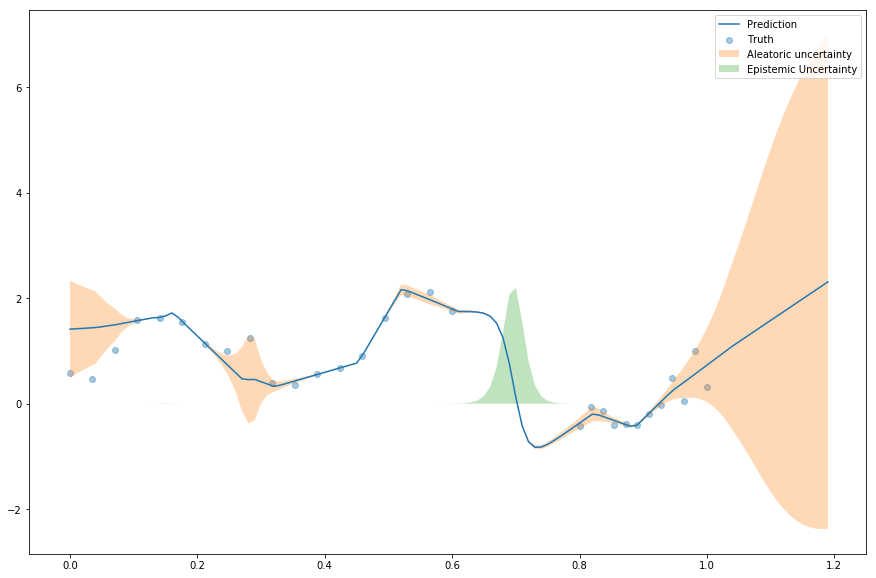

Epoch 34000
Loss -1.34247355933


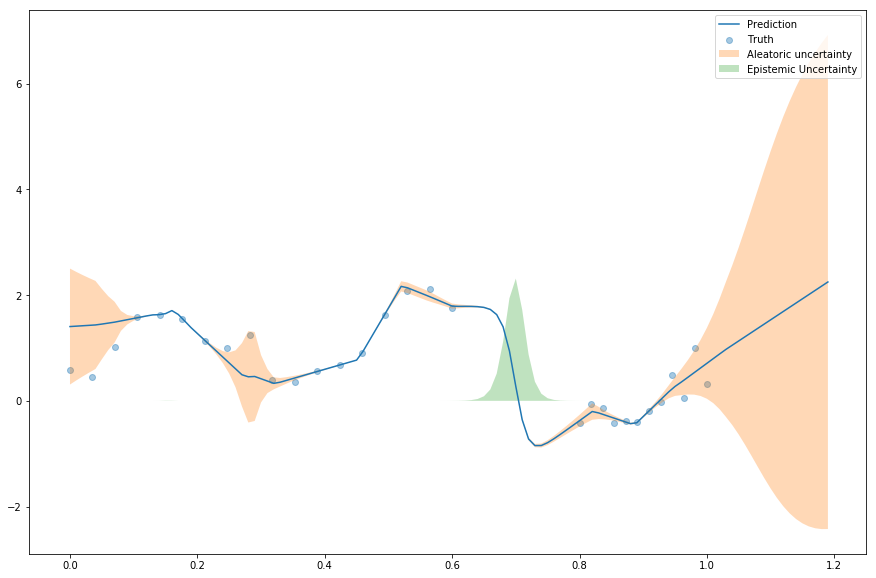

Epoch 36000
Loss -0.314313238338


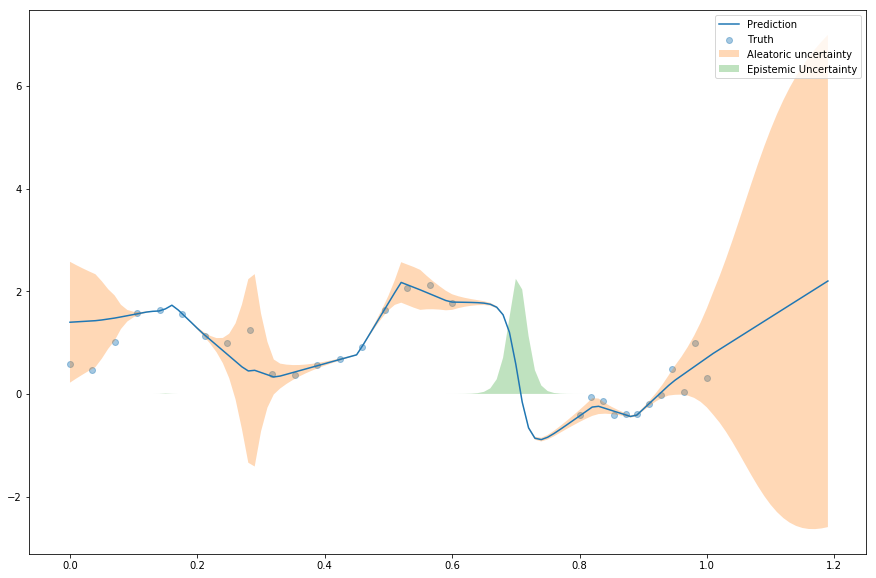

Epoch 38000
Loss -1.29198606111


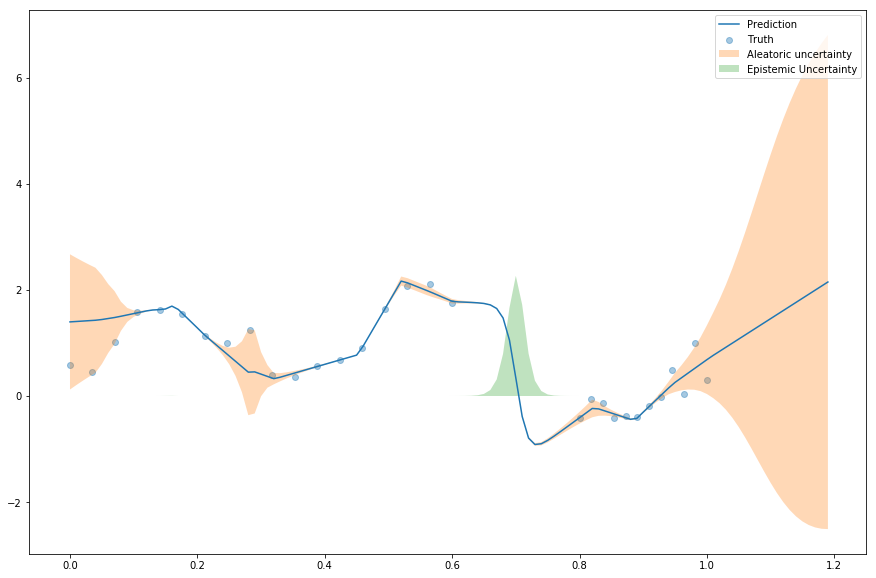

Epoch 40000
Loss -0.743963472244


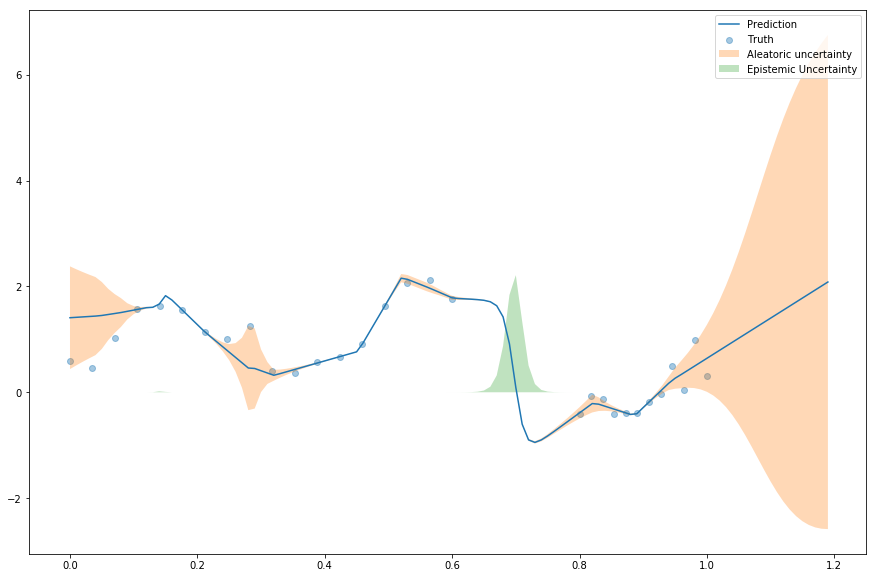

Epoch 42000
Loss -1.359225678


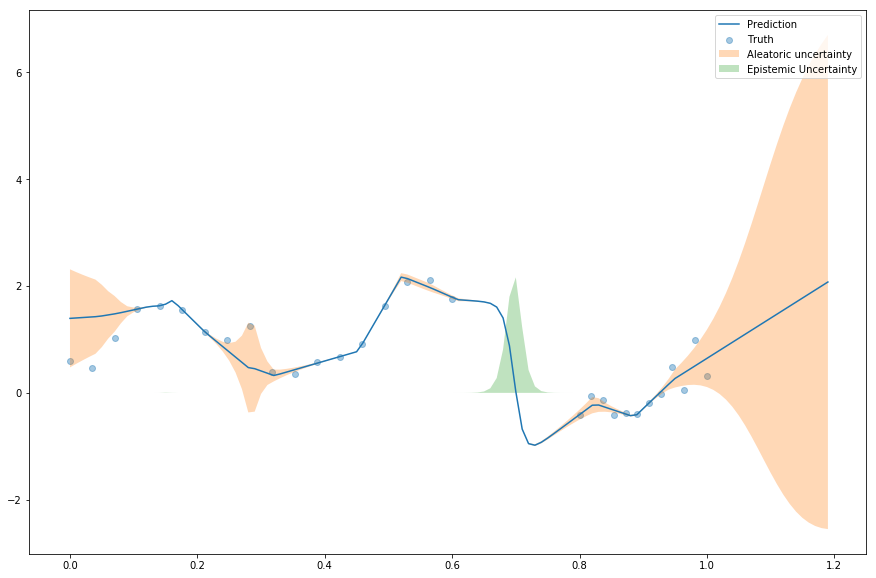

Epoch 44000
Loss -0.765165865979


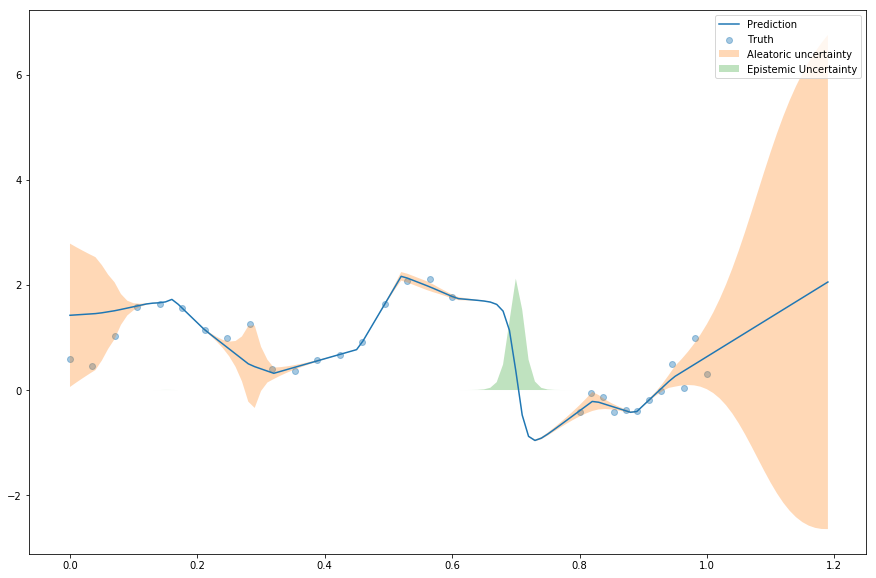

Epoch 46000
Loss -1.45584445244


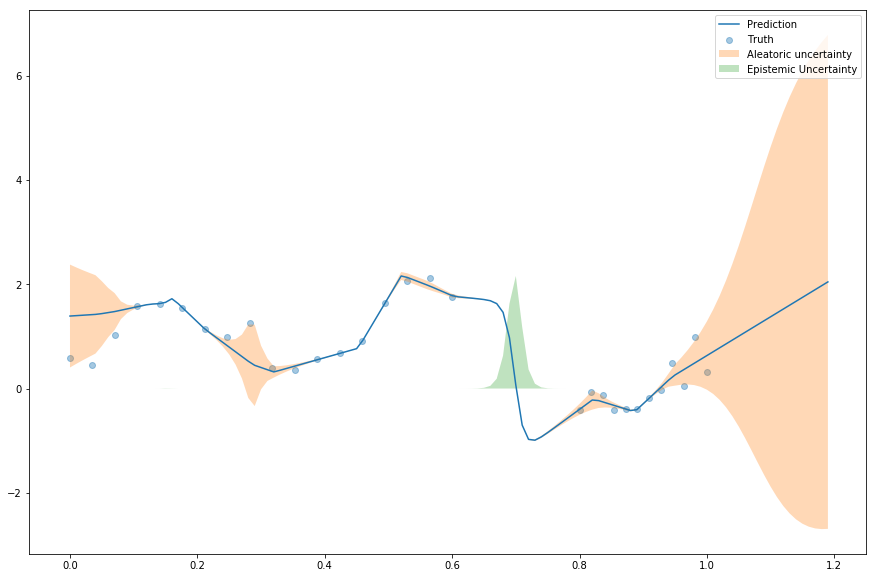

Epoch 48000
Loss -1.47846481162


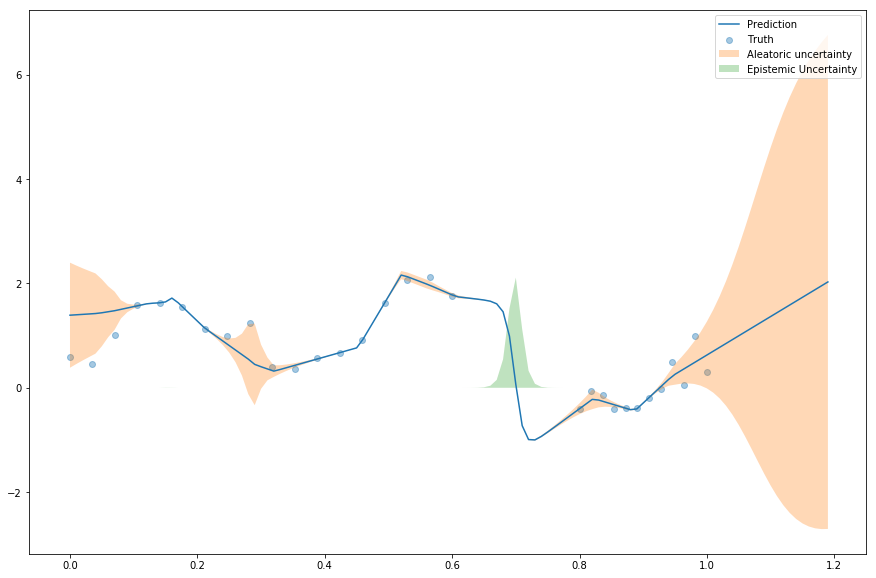

Training done


In [531]:
learning_rate = 0.001
display_step = 2000
eps = 1e-6

# each component has shape (?, n_mixtures)
mixture_weights, mixture_means, mixture_variances = mixture_density_network(x_data, n_mixtures=6)
optimizer = tf.train.AdamOptimizer(learning_rate)
dist = tf.distributions.Normal(loc=mixture_means, scale=mixture_variances)  #
loss = - tf.reduce_mean(
    tf.log(tf.reduce_sum(mixture_weights * dist.prob(y_data), axis=1) + eps),
    axis=0
)
train = optimizer.minimize(loss)

init = tf.global_variables_initializer()                                  
#sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
sess.run(init)

for epoch in range(50000):
    sess.run(train, feed_dict={x_data: x.reshape([-1, 1]),
                               y_data: y.reshape([-1, 1])})

    if (epoch % display_step == 0):
        print("Epoch {}".format(epoch))
        curLoss = sess.run(loss, feed_dict={x_data: x.reshape([-1, 1]),
                                            y_data: y.reshape([-1, 1])})  
        print("Loss {}".format(curLoss))
        print("================")
        plot()

print("Training done")

In [525]:
def plot():
    pred_range = np.arange(-0.0, 1.2, 0.01)
    pred_weights, pred_means, pred_variances = sess.run([mixture_weights, mixture_means, mixture_variances],
                      feed_dict={x_data: pred_range.reshape([-1, 1])})
    mean_y = np.sum(pred_weights * pred_means, axis=1)
    aleatoric_uncertainty = np.sum(pred_weights * pred_variances, axis=1)
    #epistemic_uncertainty = np.var(pred_weights * pred_means, axis=1)
    epistemic_uncertainty = np.sum(pred_weights * np.square(pred_means - np.expand_dims(np.sum(pred_weights * pred_means, axis=1), axis=1)), axis=1)

    plt.figure(figsize=(15, 10))
    plt.plot(pred_range, mean_y, label="Prediction")
    plt.scatter(x, y, label="Truth", alpha=0.4)
    plt.fill_between(pred_range, mean_y - aleatoric_uncertainty, mean_y + aleatoric_uncertainty, alpha=0.3,
                     label="Aleatoric uncertainty")
    plt.fill_between(pred_range, 0, epistemic_uncertainty, alpha=0.3,
                     label="Epistemic Uncertainty")
    plt.legend()
    plt.show()

Text(0.5,1,u'Variances')

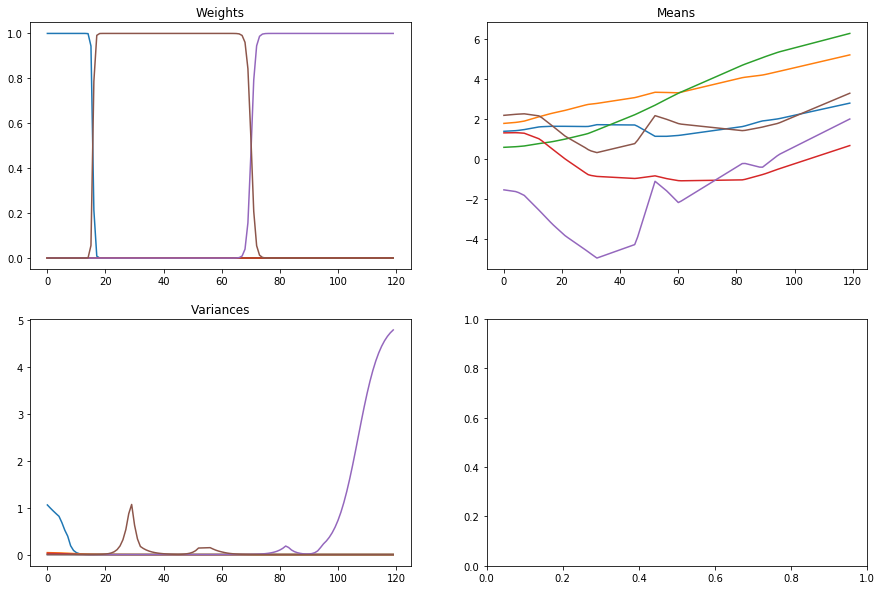

In [533]:
pred_range = np.arange(-0.0, 1.2, 0.01)
pred_weights, pred_means, pred_variances = sess.run([mixture_weights, mixture_means, mixture_variances],
                  feed_dict={x_data: pred_range.reshape([-1, 1])})
f, axs = plt.subplots(2, 2, figsize=(15,10))
axs[0,0].plot(pred_weights)
axs[0,0].set_title("Weights")
axs[0,1].plot(pred_means)
axs[0,1].set_title("Means")
axs[1,0].plot(pred_variances, label="Variance")
axs[1,0].set_title("Variances")

In [ ]:
x, y = sample_generators.generate_osband_sin_samples(size=30, variance_1=0.03, variance_2=0.09)